# 2 Player FPSB Auction with symmetric valuation distributions

## Imports

In [1]:
import os
import sys
root_path = os.path.abspath(os.path.join('..'))
if root_path not in sys.path:
    sys.path.append(root_path)

In [2]:
import torch
import torch.nn as nn
import torch.nn.utils as ut
from torch.optim.optimizer import Optimizer, required

In [3]:
from bnelearn.strategy import NeuralNetStrategy, TruthfulStrategy
from bnelearn.bidder import Bidder
from bnelearn.mechanism import FirstPriceSealedBidAuction, VickreyAuction
from bnelearn.optimizer import ES
from bnelearn.environment import AuctionEnvironment

In [4]:
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt

# set up matplotlib
is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display
#
#plt.ion()

In [5]:
cuda = torch.cuda.is_available()
device = 'cuda' if cuda else 'cpu'
print(device)

cuda


## Settings

The following cell fully defines an experiment

In [7]:
run_dir = 'fpsb_2p_symmetric_normal'
run_name = 'test_long3'
logdir = os.path.join(root_path, 'notebooks', run_dir , run_name)

## Experiment setup
n_players = 2
n_items = 1

# valuation distribution
valuation_mean = 10.0
valuation_std = 5.0

def strat_to_bidder(strategy, batch_size):
    return Bidder.normal(valuation_mean, valuation_std, strategy, batch_size = batch_size, n_players=1)

## Environment settings
#training batch size
batch_size = 2**14
input_length = 1

# strategy model architecture
size_hidden_layer = 10

# optimization params
epoch = 20000
learning_rate = 1e-1
lr_decay = True
lr_decay_every = 1000
lr_decay_factor = 0.8
baseline = True
momentum = 0.5

sigma = .02 #ES noise parameter
n_perturbations = 256

# plot and log training options
plot_epoch = 500
plot_points = min(250, batch_size)
plot_xmin = int(max(0, valuation_mean - 3*valuation_std))
plot_xmax = int(valuation_mean + 3*valuation_std)

plot_ymin = 0
plot_ymax = 15

#sample_points = torch.from_numpy(np.linspace(plot_xmin, plot_xmax, plot_xmax - plot_xmin + 1)).float().view(-1, n_items).cuda()

# tensorboard writer settings

## Optimal Bid Function

According to Menezes et al. 2005., the optimal bid for symmetric valuations $v$ that are distributed with cdf $F(v)$ for $n$ players in this setting is given by

$$b^*(v) = v - \frac{\int_0^v F(x)^{n-1} dx}{F(v)^{n-1}} $$


In [8]:
import scipy.integrate as integrate

common_dist = torch.distributions.normal.Normal(loc = valuation_mean, scale = valuation_std)

# TODO: investigate where everything is allocated. possibly move GPU vectors to CPU completely instead of shuffling around for integration?
def optimal_bid(valuation: torch.Tensor or np.ndarray or float) -> torch.Tensor:
    
    # For float and numpy --> convert to tensor
    if not isinstance(valuation, torch.Tensor):
        valuation = torch.tensor(valuation, dtype = torch.float)           
    # For float / 0d tensors --> unsqueeze to allow list comprehension below
    if valuation.dim() == 0:
        valuation.unsqueeze_(0)
    
    # shorthand notation for F^(n-1)
    Fpowered = lambda v: torch.pow(common_dist.cdf(v), n_players - 1)  
    
    # do the calculations
    numerator = torch.tensor(
            [integrate.quad(Fpowered, 0, v)[0] for v in valuation],
            device = valuation.device
        ).reshape(valuation.shape)                                 
    return valuation - numerator / Fpowered(valuation)

# Setting up the Environment

In [9]:
def log_hyperparams(writer, e):
    writer.add_scalar('hyperparams/batch_size', batch_size, e)
    writer.add_scalar('hyperparams/size_hidden_layer', size_hidden_layer, 0)
    writer.add_scalar('hyperparams/learning_rate', learning_rate, e)
    writer.add_scalar('hyperparams/momentum', momentum, e)
    writer.add_scalar('hyperparams/sigma', sigma, e)
    writer.add_scalar('hyperparams/n_perturbations', n_perturbations, e)

    
    
# predefine points for plotting optimal curve to save cpu-bound integrations
v_opt = np.linspace(plot_xmin, plot_xmax, 100) # 100 points more than enough
b_opt = optimal_bid(v_opt).numpy()

def plot_bid_function(fig, v,b, writer=None, e=None, plot_points=100):
    
    # subsample points and plot
    v = v.detach().cpu().numpy()[:plot_points]
    b= b.detach().cpu().numpy()[:plot_points]
    
    fig = plt.gcf()
    plt.cla()
    plt.xlim(plot_xmin, plot_xmax)
    plt.ylim(plot_ymin, plot_ymax)
    plt.plot(v,b, 'o', v_opt, b_opt, 'r--')
    #if is_ipython:
    #    display.clear_output(wait=True)
    display.display(plt.gcf())
    if writer:
        writer.add_figure('eval/bid_function', fig, e)  

In [10]:
model = NeuralNetStrategy(input_length,
                          size_hidden_layer = size_hidden_layer,
                          requires_grad=False
                         ).to(device)

In [11]:
mechanism = FirstPriceSealedBidAuction(cuda = True)
env = AuctionEnvironment(mechanism,
                  agents = [], #dynamically built
                  max_env_size = 1, #
                  batch_size = batch_size,
                  n_players =n_players,
                  strategy_to_bidder_closure = strat_to_bidder
                 )
optimizer = ES(model=model, environment = env,
               lr = learning_rate, momentum=momentum,
               sigma=sigma, n_perturbations=n_perturbations,
               baseline=baseline)

## Training

/opt/anaconda/anaconda3/envs/bnelearn/lib/python3.7/site-packages/ipykernel_launcher.py:20: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


Epoch 0: 	total share: 0.219798, diff: -4.678438, 	utility: 8.716963


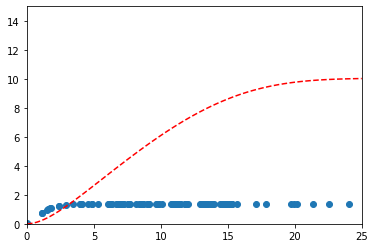

Epoch 1000: 	total share: 1.406201, diff: 2.446613, 	utility: 1.568607


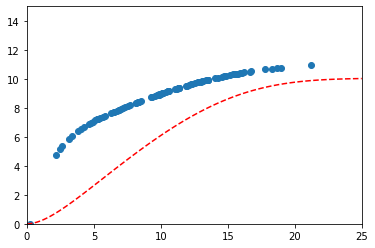

Epoch 1500: 	total share: 1.278026, diff: 1.639590, 	utility: 2.476637


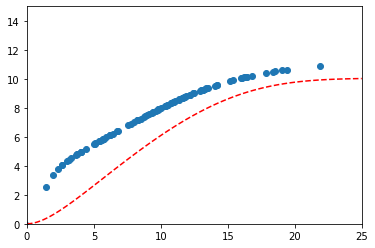

Epoch 2000: 	total share: 1.360825, diff: 2.103664, 	utility: 2.085255


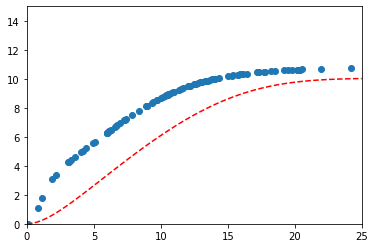

Epoch 2500: 	total share: 1.184739, diff: 1.078290, 	utility: 3.153200


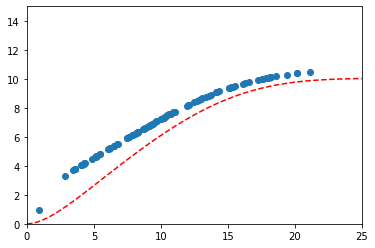

Epoch 3000: 	total share: 1.077494, diff: 0.454931, 	utility: 3.666798


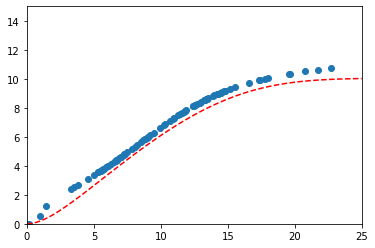

/opt/anaconda/anaconda3/envs/bnelearn/lib/python3.7/site-packages/ipykernel_launcher.py:20: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


Epoch 3500: 	total share: 0.724242, diff: -2.361904, 	utility: 3.881908


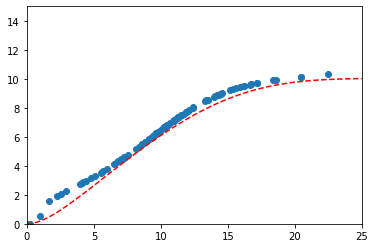

Epoch 4000: 	total share: 0.977800, diff: -0.130204, 	utility: 4.313279


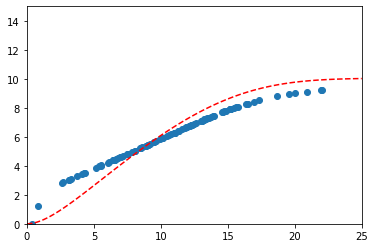

Epoch 4500: 	total share: 1.125079, diff: 0.765863, 	utility: 3.128328


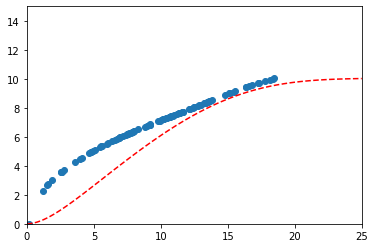

Epoch 5000: 	total share: 1.189767, diff: 1.157718, 	utility: 2.777835


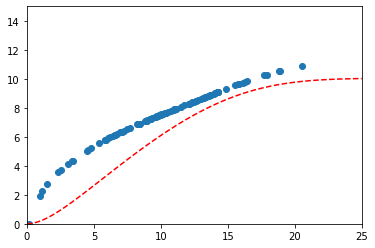

Epoch 5500: 	total share: 1.107065, diff: 0.652457, 	utility: 3.341952


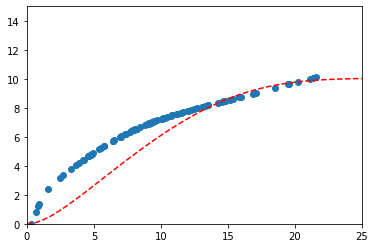

Epoch 6000: 	total share: 1.202950, diff: 1.198008, 	utility: 2.948932


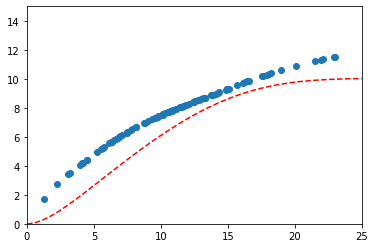

In [ ]:
with SummaryWriter(logdir, flush_secs=120) as writer:
    torch.cuda.empty_cache()
    log_hyperparams(writer, 0)
    fig = plt.figure()
    for e in range(epoch+1):
        # lr decay?
        if lr_decay and e % lr_decay_every == 0 and e > 0:
            learning_rate = learning_rate * lr_decay_factor
            log_hyperparams(writer, e)
            for param_group in optimizer.param_groups:
                param_group['lr'] = learning_rate

        # always: do optimizer step
        utility = -optimizer.step()
        writer.add_scalar('eval/utility', utility, e)

        if e % plot_epoch == 0:
            # plot current function output
            bidder = strat_to_bidder(model, batch_size)
            bidder.draw_valuations_()
            v = bidder.valuations
            b = bidder.get_action()
            
            opt_bid = optimal_bid(v)
            
            share = b.mean()/opt_bid.mean()
            diff = (b-opt_bid).mean()
            writer.add_scalar('eval/share', share, e)
            writer.add_scalar('eval/diff', diff, e) 


            print("Epoch {}: \ttotal share: {:2f}, diff: {:2f}, \tutility: {:2f}".format(e, share, diff, utility))
            plot_bid_function(fig, v,b,writer,e)        

            writer.add_graph(model, bidder.valuations)